In [7]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

27296


## printing params

In [8]:
# Required plotting setting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')

from ImageAnalysis3.figure_tools import _single_col_width, _font_size, _ticklabel_size,_ticklabel_width

#import seaborn as sns
#sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [9]:
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
print(postanalysis_folder)
dark_mode = True
if dark_mode:
    figure_folder = os.path.join(postanalysis_folder, 'Figures_0903_dark')
    plt.style.use('dark_background')
else:
    figure_folder = os.path.join(postanalysis_folder, 'Figures_0817')
print(figure_folder)

# figure for chromosomes
chrom_figure_folder = os.path.join(figure_folder, 'Chromosomes')
if not os.path.exists(chrom_figure_folder):
    print(f"Create chrom_figure_folder: {chrom_figure_folder}")
    os.makedirs(chrom_figure_folder)
else:
    print(f"Use chrom_figure_folder: {chrom_figure_folder}")

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis
\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\Figures_0903_dark
Create chrom_figure_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\Figures_0903_dark\Chromosomes


## load codebook

In [10]:
import pandas as pd
codebook = pd.read_csv(r'\\10.245.74.158\Chromatin_NAS_8\Exported_data\20220713-Export\merged_codebook.csv')

sort_by_region = False
from ImageAnalysis3.structure_tools import distance

chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook, codebook, sort_by_region=sort_by_region)

## Load coordinates for subtypes

In [11]:
subclass_2_chr2Zxys_filename = os.path.join(postanalysis_folder, 'subclass_2_chr2Zxys.pkl')
subclass_2_chr2ZxysList = pickle.load(open(subclass_2_chr2Zxys_filename, 'rb'))

In [12]:
for _subcls in subclass_2_chr2ZxysList:
    print(_subcls, len(subclass_2_chr2ZxysList[_subcls]))

Oligo 4765
L6b 741
Astro 3822
VLMC 444
OPC 1568
Endo 2891
L6 CT 4234
Peri 738
Micro 1523
L6 IT 1837
Sncg 133
L2/3 IT 3095
Sst 746
L5 IT 2014
Vip 357
Pvalb 993
Lamp5 339
L5/6 NP 596
L5 ET 1202
L4/5 IT 2398
SMC 434
other 311


## convert to major class

In [13]:
class_2_subclass = {
    'Gluta':['L6b', 'L6 CT', 'L6 IT', 'L5 IT', 'L2/3 IT', 'L5/6 NP', 'L5 ET', ],
    'GABA':['Sncg', 'Sst', 'Vip', 'Pvalb', 'Lamp5', 'L4/5 IT', ],
    'Astro':['Astro', ],
    'Endo':['Endo', ],
    'Micro':['Micro', ],
    'Oligo':['Oligo', 'OPC', ],
}
subclass_2_class = {}
for _cls in class_2_subclass:
    for _subcls in class_2_subclass[_cls]:
        subclass_2_class[_subcls] = _cls

In [14]:
# save if not exists
class_2_chr2ZxysList_filename = os.path.join(postanalysis_folder, 'class_2_chr2Zxys.pkl')
if not os.path.exists(class_2_chr2ZxysList_filename):
    # calculate
    class_2_chr2ZxysList = {_cls:[] for _cls in class_2_subclass.keys()}
    for _subcls, _chr2ZxysList in subclass_2_chr2ZxysList.items():
        if _subcls in subclass_2_class:
            class_2_chr2ZxysList[subclass_2_class[_subcls]].extend(_chr2ZxysList)
    # plot stats
    for _cls in class_2_chr2ZxysList:
        print(_cls, len(class_2_chr2ZxysList[_cls]))
    # save
    print(f"Writing to file: {class_2_chr2ZxysList_filename}")
    pickle.dump(class_2_chr2ZxysList, open(class_2_chr2ZxysList_filename, 'wb'))
else:
    print("Loading")
    class_2_chr2ZxysList = pickle.load(open(class_2_chr2ZxysList_filename, 'rb'))

Loading


## Select good cells

In [15]:
from ImageAnalysis3.figure_tools.plot_decode import Centering_Chr2ZxysListDict

In [16]:
class_2_selChr2ZxysList = {_cls:[] for _cls in class_2_chr2ZxysList.keys()}
num_chr = 20

for _cls, _chr2ZxysList in class_2_chr2ZxysList.items():
    for _chr2Zxys in _chr2ZxysList:
        if len(_chr2Zxys) >= 19:
             class_2_selChr2ZxysList[_cls].append(Centering_Chr2ZxysListDict(_chr2Zxys))
# plot stats
for _cls in class_2_chr2ZxysList:
    print(_cls, len(class_2_chr2ZxysList[_cls]), len(class_2_selChr2ZxysList[_cls]))

Gluta 13719 2580
GABA 4966 1097
Astro 3822 601
Endo 2891 542
Micro 1523 442
Oligo 6333 2168


# Genome volume

In [17]:
from scipy.spatial import ConvexHull

class_2_volumes = {}
for _cls in class_2_selChr2ZxysList.keys():
    _volumes = []
    for _chr2Zxys in class_2_selChr2ZxysList[_cls]:
        _cell_zxys = np.concatenate([np.array(_v).reshape(-1, 3) for _k,_v in _chr2Zxys.items()])
        _cell_valid_zxys = _cell_zxys[np.isnan(_cell_zxys).any(1)==False]
        _hull = ConvexHull(_cell_valid_zxys)
        _volumes.append(_hull.volume)
    class_2_volumes[_cls] = _volumes

<IPython.core.display.Javascript object>


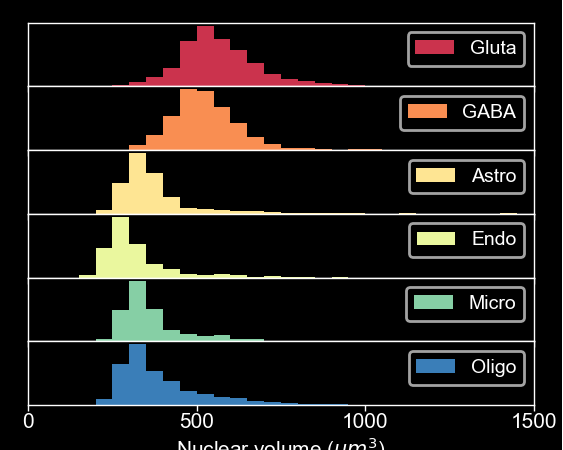

In [18]:
from matplotlib.cm import Spectral

sel_keys = list(class_2_volumes.keys())
#plt.style.use('default')

#fig, axes = plt.subplots(,1, figsize=(6,5), sharex=True, sharey=False, dpi=100)
fig, axes = plt.subplots(len(sel_keys),1, figsize=(_single_col_width*1.25, _single_col_width),
                         sharex=True, dpi=200)

for _i, _ax in enumerate(axes):
    _key = sel_keys[_i]
    _ax.hist(class_2_volumes[_key], bins=np.arange(0,1500,50), 
             alpha=1, label=f'{_key}', color=Spectral((_i+0.5)/len(sel_keys)))
    _ax.legend(fontsize=_font_size-0.5)
    
    _ax.tick_params('x', labelsize=_font_size, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    labelleft=False,
                    pad=1, )
    _ax.tick_params('y', labelsize=_font_size, 
                    width=0, length=0,
                    labelleft=False,
                    pad=1, )
    [i[1].set_linewidth(_ticklabel_width) for i in _ax.spines.items()]

_ax.set_xticks(np.arange(0,2000,500))
_ax.set_xlim([0,1500])
_ax.set_xlabel(f"Nuclear volume ($\u03BCm^3$)", fontsize=_font_size, labelpad=1)
fig.subplots_adjust(wspace=0.1, hspace=0., left=0.05, right=0.95, top=0.95, bottom=0.1)
fig.savefig(os.path.join(chrom_figure_folder, f"volume_histogram_class.pdf"),
            transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=300)
fig.savefig(os.path.join(chrom_figure_folder, f"volume_histogram_class.png"),
            transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

In [21]:
_vols

[570.6060096851978,
 411.2130686123154,
 397.11640370870276,
 671.7958987328352,
 544.3929687889716,
 508.66297717978034,
 444.56175968989174,
 750.0424658784337,
 610.5239368468182,
 495.7876531398139,
 604.0569640282498,
 289.91084354205435,
 578.9794420568879,
 618.1430226547759,
 727.134590759773,
 663.0274727348091,
 528.854077027871,
 636.7773019242152,
 496.1134977786393,
 665.3507193979352,
 405.2138177248202,
 331.8380202974608,
 466.6431892125787,
 327.10033831117033,
 535.0500839453192,
 347.7279823282557,
 680.313410199769,
 503.7595244879084,
 405.0189894367295,
 326.99035700252153,
 588.9120948788759,
 773.7134994509628,
 310.46247910999966,
 514.7567551066359,
 372.9269936468363,
 353.91074033902595,
 927.7145223521554,
 617.9568168751407,
 566.4623942227472,
 572.2444486217045,
 583.6072004198509,
 827.6198281767244,
 593.5672340295786,
 476.6343047747417,
 502.67015922473325,
 583.9039104058834,
 471.7150106920615,
 316.0455883347179,
 488.44000003223414,
 518.85389957

<IPython.core.display.Javascript object>


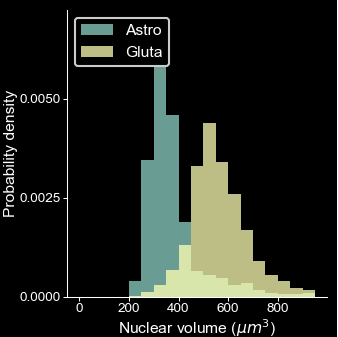

In [27]:
plot_classes = ['Astro','Gluta']

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=150)


for _cls in plot_classes:
    # extract values
    _vols = class_2_volumes[_cls]
    ax.hist(_vols, bins=np.arange(0,1000,50), alpha=0.75, density=True, label=f"{_cls}")

    
ax.set_yticks(np.arange(0,0.006,0.0025))
ax.legend(fontsize=_font_size, loc='upper left', frameon=True, framealpha=1)

ax.set_xlabel(f"Nuclear volume ($\u03BCm^3$)", fontsize=_font_size, labelpad=1)
ax.set_ylabel(f"Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines["top"].set_visible(False) # remove top frame
ax.spines["right"].set_visible(False) #remove right frame

fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.2, right=0.97, top=0.97, bottom=0.12)
plt.savefig(os.path.join(chrom_figure_folder, f"histogram_volumes.pdf"),
            transparent=True, bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(chrom_figure_folder, f"histogram_volumes.png"),
            transparent=True, bbox_inches='tight', dpi=300)
plt.show()

# Chromosome density

In [12]:
_px = 0.1
_sigma = 0.25
_im_radius = 5

num_threads=40

import multiprocessing as mp
from ImageAnalysis3.structure_tools.chromosome import convert_chr2Zxys_2_Cloud
reload(ia.structure_tools.chromosome)


<module 'ImageAnalysis3.structure_tools.chromosome' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\structure_tools\\chromosome.py'>

In [13]:
class_2_chr2densities = {}

for _class, _chr2ZxysList in class_2_chr2ZxysList.items():
    _args = []
    for _chr2Zxys in _chr2ZxysList:
        _args.append(
            (_chr2Zxys, _px, _im_radius, _sigma, [1,2], 20, 0.5, False, False, False)
        )
    with mp.Pool(num_threads) as _pool:
        print(f"--- {_class}, {len(_args)} cells processing by {num_threads} threads", end=' ')
        _start_time = time.time()
        # pool
        _chr2densities_List = _pool.starmap(
            ia.structure_tools.chromosome.convert_chr2Zxys_2_Cloud, _args, chunksize=1)
        _pool.close()
        _pool.join()
        _pool.terminate() 
        print(f"finish in {time.time()-_start_time:.3f}s. ")
    
    class_2_chr2densities[_class] = _chr2densities_List
    

--- Gluta, 13719 cells processing by 40 threads finish in 1500.622s. 
--- GABA, 4966 cells processing by 40 threads finish in 988.196s. 
--- Astro, 3822 cells processing by 40 threads finish in 214.870s. 
--- Endo, 2891 cells processing by 40 threads finish in 85.882s. 
--- Micro, 1523 cells processing by 40 threads finish in 81.535s. 
--- Oligo, 6333 cells processing by 40 threads finish in 349.169s. 


In [20]:
# save if not exists
class_2_chr2densities_filename = os.path.join(postanalysis_folder, 'class_2_chrdensity_array.pkl')
if not os.path.exists(class_2_chr2densities_filename):

    # save
    print(f"Writing to file: {class_2_chr2densities_filename}")
    pickle.dump(class_2_chr2densities, open(class_2_chr2densities_filename, 'wb'))

Writing to file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\class_2_chrdensity_array.pkl


In [14]:
chromosome_th = 2

class_2_chr2volumes = {_cls:{_chr:[] for _chr in np.unique(codebook['chr'])}
                       for _cls in class_2_chr2densities}
for _class, _chr2densities_List in class_2_chr2densities.items():
    for _chr2densities in _chr2densities_List:
        for _chr, _dens in _chr2densities.items():
            for _den in _dens:
                if _den.any():
                    class_2_chr2volumes[_class][_chr].append(
                        np.sum(_den > chromosome_th) * _px**3
                    )

<IPython.core.display.Javascript object>


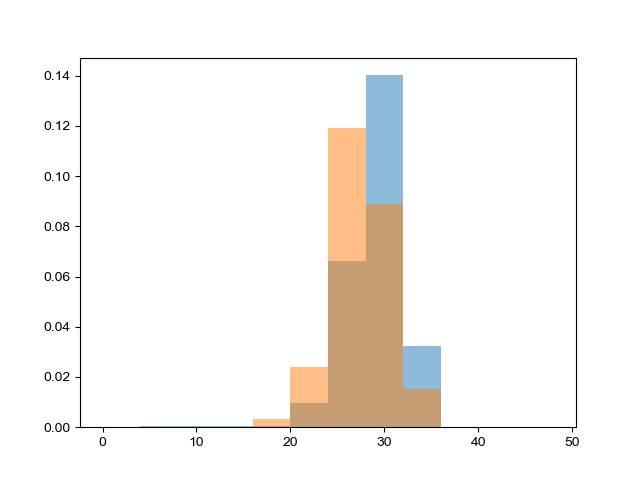

(array([0.        , 0.        , 0.        , 0.        , 0.00324675,
        0.02380952, 0.11904762, 0.08874459, 0.01515152, 0.        ,
        0.        , 0.        ]),
 array([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]),
 <BarContainer object of 12 artists>)

In [29]:
plt.figure()
plt.hist(class_2_chr2volumes['Gluta']['7'], density=True, bins=np.arange(0,50,4), alpha=0.5)
plt.hist(class_2_chr2volumes['Oligo']['7'], density=True, bins=np.arange(0,50,4), alpha=0.5)

In [ ]:
30*20

<IPython.core.display.Javascript object>


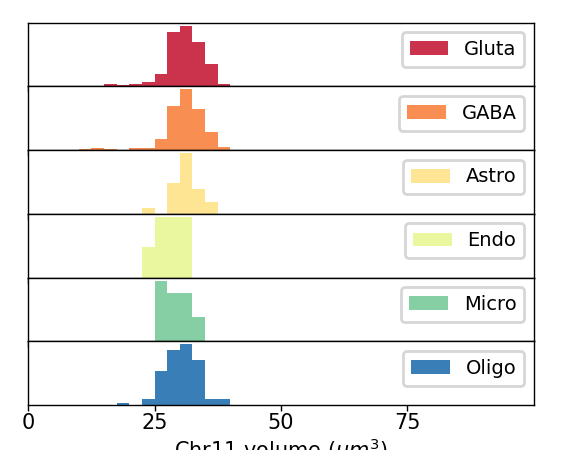

In [34]:
from matplotlib.cm import Spectral

sel_keys = list(class_2_chr2volumes.keys())
#sel_chr = '7'
sel_chr = '11'
plt.style.use('default')

#fig, axes = plt.subplots(,1, figsize=(6,5), sharex=True, sharey=False, dpi=100)
fig, axes = plt.subplots(len(sel_keys),1, figsize=(_single_col_width*1.25, _single_col_width),
                         sharex=True, dpi=200)

for _i, _ax in enumerate(axes):
    _key = sel_keys[_i]
    _hists = _ax.hist(class_2_chr2volumes[_key][sel_chr], bins=np.arange(0,100,2.5), 
                      alpha=1, label=f'{_key}', color=Spectral((_i+0.5)/len(sel_keys)))
    _ax.legend(fontsize=_font_size-0.5)
    
    _ax.tick_params('x', labelsize=_font_size, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    labelleft=False,
                    pad=1, )
    _ax.tick_params('y', labelsize=_font_size, 
                    width=0, length=0,
                    labelleft=False,
                    pad=1, )
    [i[1].set_linewidth(_ticklabel_width) for i in _ax.spines.items()]

_ax.set_xticks(np.arange(0,100,25))
_ax.set_xlim([0,100])
_ax.set_xlabel(f"Chr{sel_chr} volume ($\u03BCm^3$)", fontsize=_font_size, labelpad=1)
fig.savefig(os.path.join(chrom_figure_folder, f"chr{sel_chr}_volume_histogram_class.pdf"),
            transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=300)
fig.subplots_adjust(wspace=0.1, hspace=0., left=0.05, right=0.95, top=0.95, bottom=0.1)


In [20]:
for _chr2densities in _chr2densities_List:
    if '4' in _chr2densities and _chr2densities['4'].any():
        break

<IPython.core.display.Javascript object>


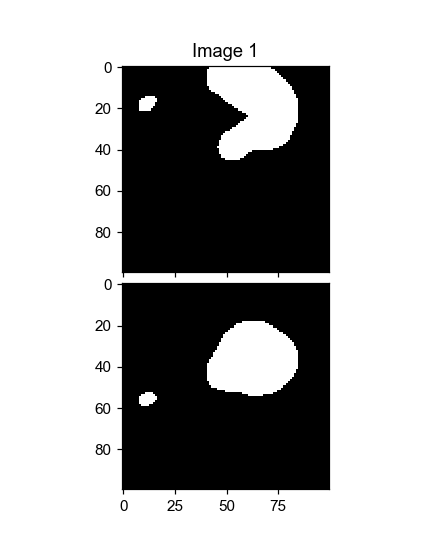

In [30]:
visual_tools.imshow_mark_3d_v2(_chr2densities['9'] > 2 )